### Import Libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import warnings
import time
import re
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectFwe
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR

## 1. Import Data from Preprocessing

In [2]:
#df_joined = pd.read_csv("regressionPreprocessingGeneral.csv")

df_joined = pd.read_csv("regressionPreprocessingWithClustering.csv")
df_joined['rating'] =  df_joined['rating_x']

df_joined = df_joined.fillna(0)
print("Length after import: " + str(len(df_joined)))
print("Features after import: " + str(len(df_joined.columns)))
df_joined[['usercluster','rating_x','rating_y']].head(5)

Length after import: 118856
Features after import: 69


,usercluster,rating_x,rating_y
0,0,3.772727,3.888157
1,1,3.937061,3.888157
2,2,3.928131,3.888157
3,3,3.907481,3.888157
4,4,3.895459,3.888157


In [3]:
df_joined.groupby('rating')['rating'].min()

rating
0.500000    0.500000
0.583333    0.583333
0.625000    0.625000
0.642857    0.642857
0.666667    0.666667
              ...   
4.875000    4.875000
4.900000    4.900000
4.916667    4.916667
4.928571    4.928571
5.000000    5.000000
Name: rating, Length: 24402, dtype: float64

### Remove Features (if needed)

In [4]:
features_to_remove = ['movieId', 'rating_x','rating_y', 'id','18+','actors','productionCompanies','productionCountries','imdbId','spokenLanguages','budget_norm','runtime_norm']
for i in features_to_remove:
    if i in df_joined.columns:
        df_joined = df_joined.drop(columns=i)
print("Features: ", len(df_joined.columns))
df_joined.head(5)

Features:  61


,usercluster,budget,runtime,Documentary,Foreign,Action,Horror,War,Romance,Adventure,...,actor_Donald Sutherland,actor_Robert De Niro,actor_Samuel L. Jackson,actor_Jackie Chan,actor_Michael Caine,actor_Christopher Lee,actor_Frank Welker,actor_John Carradine,actor_Gérard Depardieu,rating
0,0,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3.772727
1,1,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3.937061
2,2,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3.928131
3,3,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3.907481
4,4,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3.895459


### Encode Director

In [5]:
lab_enc = LabelEncoder()
df_joined["director"] = df_joined["director"].astype(str)
df_joined["director"] = lab_enc.fit_transform(df_joined["director"])
df_joined.director.head(3)

0    10828
1    10828
2    10828
Name: director, dtype: int32

### Train and Test Split (needed for Feature Selection)

The algorithms used for feature selection need the data separated in train and test data.

In [6]:
df_joined_pipeline = df_joined.copy()
df_joined_copy = df_joined.copy()
rating = df_joined['rating']

features = df_joined_copy.drop(columns=['rating'])
features_train, features_test, rating_train, rating_test = train_test_split(
    features, rating, test_size=0.3, random_state=42)

print("Train: " + str(len(features_train)) + " Feature Entries and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features Entries and " + str(len(rating_test)) + " Ratings")

Train: 83199 Feature Entries and 83199 Ratings
Test: 35657 Features Entries and 35657 Ratings


## 2. Feature Selection

### 2.1. XGBoost Regressor

In [7]:
regressor = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 4, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')
regressor.fit(features_train, rating_train)

bestFeaturesXGB = []
importances = {}

count = 0
for feature_importance in regressor.feature_importances_:
    if feature_importance > 0.01:
        feature_name = features_train.columns[count]
        importances[feature_name] = feature_importance
    count+=1

for key, value in sorted(importances.items(), key=lambda item: item[1], reverse=True):
    #print("%s: %s" % (key, value))
    if key not in bestFeaturesXGB:
        bestFeaturesXGB.append(key)
print(bestFeaturesXGB)

['Drama', 'Horror', 'usercluster', 'Documentary', 'Action', 'Science Fiction', 'Comedy', 'History', 'Family', 'Animation', 'Mystery', 'Crime', 'War', 'Music', 'Adventure', 'Thriller', 'Romance', 'Fantasy', 'hasHomepage']


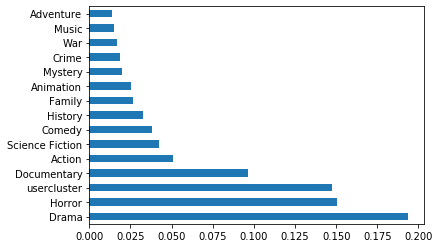

In [8]:
feat_importances = pd.Series(regressor.feature_importances_, index=features_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

### 2.2. F Regression

In [9]:
reg = LinearRegression()
reg.fit(features_train, rating_train)
mse = mean_squared_error(rating_test, reg.predict(features_test))
print("RMSE:", sqrt(mse))

RMSE: 0.7822879623194358


In [10]:
from sklearn.feature_selection import f_regression

# run the F-Test
f, pval = f_regression(features_train, rating_train)

# prepare a dataframe to inspect the results
stat = pd.DataFrame({ 'feature': features_train.columns, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)
stat = stat.sort_values("p value", ascending=False)[:10]
# show the results
display(stat)

,feature,F value,p value
15,TV Movie,0.000325,0.99
25,hasHomepage,0.081255,0.78
17,Western,0.147052,0.70
4,Foreign,4.436939,0.04
26,director,7.402620,0.01
14,Comedy,166.942926,0.00
23,part_of_collection,14.710669,0.00
22,Science Fiction,522.818392,0.00
21,Music,56.848470,0.00
20,Animation,27.802476,0.00


In [11]:
best = SelectFwe(f_regression, alpha=0.05)

estimator = LinearRegression()
pipeline = Pipeline([ ('feature_selection', best), ('estimator', estimator)])

# fit the regression on the training data
pipeline.fit(features_train, rating_train)

# predict the values for the test data
predictions = pipeline.predict(features_test)

# evaluate on the test set
rmse = sqrt(mean_squared_error(rating_test, predictions))
print("RMSE:", rmse)

RMSE: 0.7824346866265118


In [12]:
features_train_selected = best.fit_transform(features_train, rating_train)

# run the F-Test
f, pval = f_regression(features_train_selected, rating_train)

# prepare a dataframe to inspect the results
new_feature_names = [feature_name for (is_used, feature_name) in zip(best.get_support(), features_train.columns) if is_used]

stat = pd.DataFrame({ 'feature': new_feature_names, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)
stat = stat.sort_values("p value", ascending=False)
# show the results
display(stat)

bestFeaturesFRegression = new_feature_names
print(bestFeaturesFRegression)

,feature,F value,p value
0,usercluster,2156.740465,0.0
11,Drama,2773.108811,0.0
19,Science Fiction,522.818392,0.0
18,Music,56.848470,0.0
17,Animation,27.802476,0.0
16,Fantasy,21.262437,0.0
15,Mystery,22.593716,0.0
14,Crime,98.513734,0.0
13,Comedy,166.942926,0.0
12,Family,204.874062,0.0


['usercluster', 'budget', 'runtime', 'Documentary', 'Action', 'Horror', 'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama', 'Family', 'Comedy', 'Crime', 'Mystery', 'Fantasy', 'Animation', 'Music', 'Science Fiction', 'part_of_collection']


### 2.3. Select K Best

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

bestFeaturesKBest = []

selector = SelectKBest(f_regression, k=10)
fit = selector.fit(features_train,rating_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
print("## F-Regression: ")
print(featureScores.nlargest(15,'Score'))
for index,row in featureScores.sort_values('Score',ascending=False)[:10].iterrows():
    if row.Features not in bestFeaturesKBest:
        bestFeaturesKBest.append(row.Features)

print("\nBest Features from K-Best: ", bestFeaturesKBest)

## F-Regression: 
           Features        Score
12            Drama  2773.108811
6            Horror  2347.196637
0       usercluster  2156.740465
3       Documentary   631.399525
22  Science Fiction   522.818392
5            Action   522.540522
11          History   444.397398
13           Family   204.874062
8           Romance   198.836397
7               War   198.127467
14           Comedy   166.942926
10         Thriller   129.771959
2           runtime   102.587538
16            Crime    98.513734
9         Adventure    78.567665

Best Features from K-Best:  ['Drama', 'Horror', 'usercluster', 'Documentary', 'Science Fiction', 'Action', 'History', 'Family', 'Romance', 'War']


### 2.4. Merge Results

In [14]:
# XGB Regressor --> bestFeaturesXGB
# F-Regression with PolynomialFeatures --> bestFeaturesFRegression
# Select K Best --> bestFeaturesKBest
print(len(bestFeaturesXGB))
print(len(bestFeaturesFRegression))
print(len(bestFeaturesKBest))

bestFeatures = list(set().union(bestFeaturesXGB, bestFeaturesFRegression, bestFeaturesKBest))
print("Nr of selected features: ",len(bestFeatures))
print("Best features: ",bestFeatures)

19
21
10
Nr of selected features:  22
Best features:  ['Action', 'budget', 'Music', 'part_of_collection', 'usercluster', 'Romance', 'Fantasy', 'Comedy', 'Horror', 'Thriller', 'Mystery', 'hasHomepage', 'Drama', 'Family', 'Documentary', 'Adventure', 'History', 'Crime', 'Science Fiction', 'runtime', 'War', 'Animation']


### 2.5. Correlation Analysis

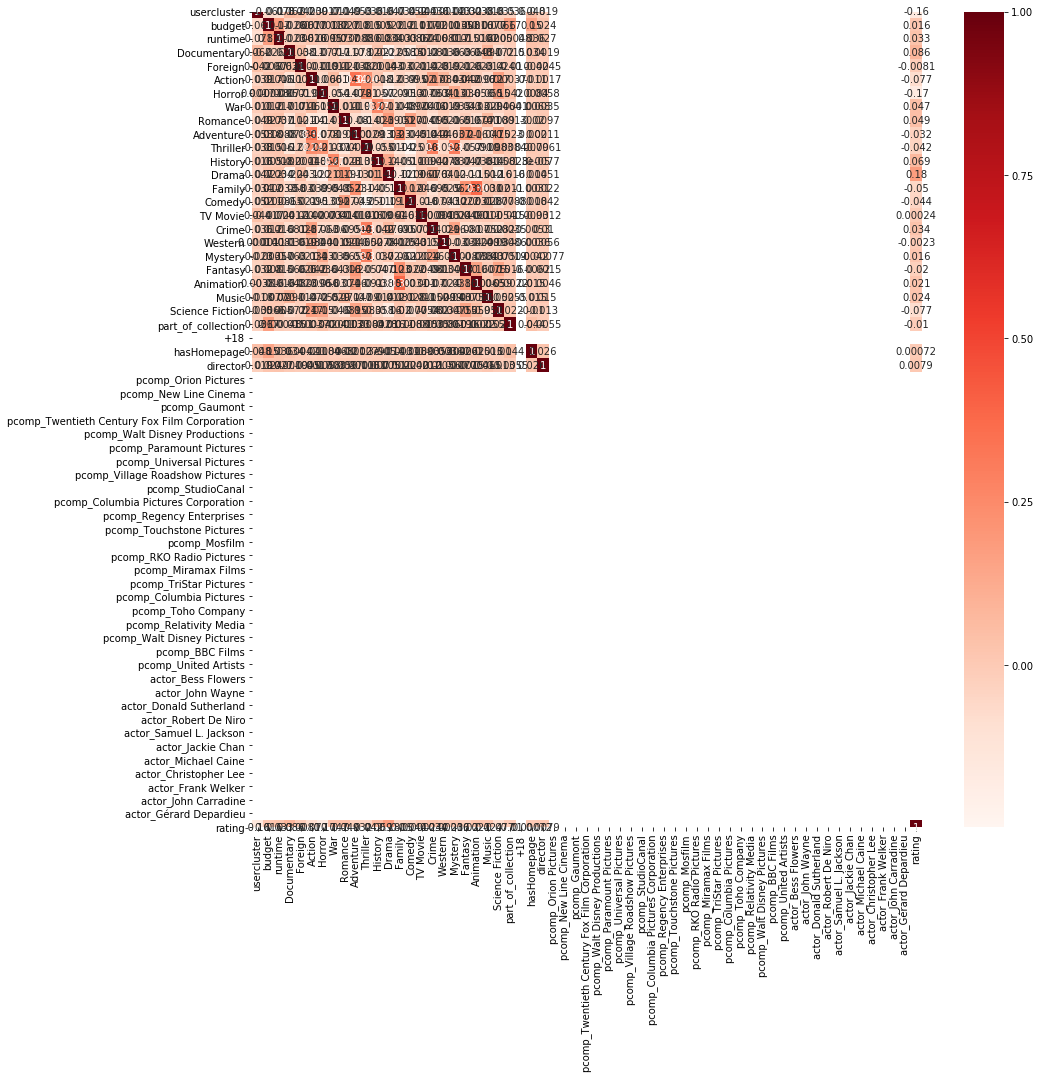

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Pearson Correlation (0 no correlation, 1 stronger positive correlation, -1 stronger negative correlation)
plt.figure(figsize=(15,15))
df_joined['rating'] = rating
cor = df_joined.corr()
sns.heatmap(cor, annot=True, cmap = plt.cm.Reds)
plt.show()

### 2.6. Remove features, which are not relevant

In [16]:
rating = df_joined['rating']

for i in df_joined.columns:
    if i not in bestFeatures:
        df_joined = df_joined.drop(columns=i)

print("Selected features: ", len(df_joined.columns))
df_joined.head(5)

Selected features:  22


,usercluster,budget,runtime,Documentary,Action,Horror,War,Romance,Adventure,Thriller,...,Family,Comedy,Crime,Mystery,Fantasy,Animation,Music,Science Fiction,part_of_collection,hasHomepage
0,0,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
1,1,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
2,2,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
3,3,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
4,4,30000000,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0


As we can see Horror and usercluster have the most negative and drama the most positive influence on rating.

## 3. Split again only with selected attributes

In [17]:
features = preprocessing.scale(df_joined)
#features = df_joined

# create a train/test split
features_train, features_test, rating_train, rating_test = train_test_split(
    features, rating, test_size=0.3, random_state=42)

print("Train: " + str(len(features_train)) + " Feature Entries and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features Entries and " + str(len(rating_test)) + " Ratings")
print(len(df_joined.columns))

Train: 83199 Feature Entries and 83199 Ratings
Test: 35657 Features Entries and 35657 Ratings
22


## 4. First run (trying all algorithms with default parameters)

### 4.1. Measure Function
#### This function contains the most important measures to evaluate a regression model. 

In [25]:
def executeModel(model, withFit=True):
    if withFit:
        model.fit(features_train,rating_train)
    
    y_pred = model.predict(features_test)
    
    scores = cross_val_score(model, features_test, rating_test, scoring='r2')
    
    print("Score (Average): ", scores.mean())
    print("MAE: ", mean_absolute_error(rating_test, y_pred))
    print("MSE: ", mean_squared_error(rating_test, y_pred))
    print("RMSE: ", sqrt(mean_squared_error(rating_test, y_pred)))
    print("R^2: ", r2_score(rating_test,y_pred))
    
    # visualization of the first 30 test records
    plt.scatter(y_pred, rating_test, c='blue', label='test')
    plt.xlabel('predicted')
    plt.ylabel('correct')
    plt.legend()
    plt.show()

### 4.2. Run common regression algorithms

### Linear Regression ###
Score (Average):  0.09446715165155524
MAE:  0.5812432443837445
MSE:  0.6121789949669088
RMSE:  0.7824186826545675
R^2:  0.09504366893405547


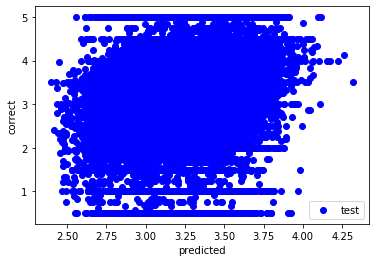


### Ridge ###
Score (Average):  0.09446724913904374
MAE:  0.5812433101425902
MSE:  0.612178958349776
RMSE:  0.7824186592546065
R^2:  0.0950437230634954


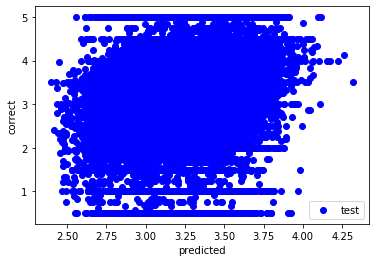


### Bayesian Ridge ###
Score (Average):  0.09447814204145162
MAE:  0.5812569643088642
MSE:  0.6121718930089455
RMSE:  0.7824141441774589
R^2:  0.09505416743510609


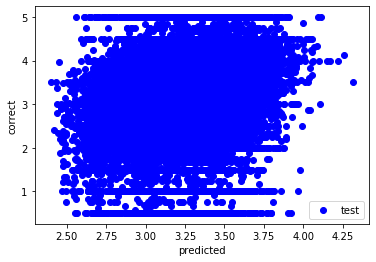


### Ada Boost Regressor ###
Score (Average):  -0.09106109724457623
MAE:  0.6135052759252514
MSE:  0.7143786672416842
RMSE:  0.8452092446499175
R^2:  -0.05603345265670101


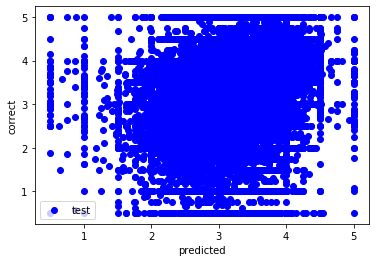


### Ada Boost Regressor (different values) ###
Score (Average):  -0.12660880784305872
MAE:  0.6964718941452096
MSE:  0.7598461112407018
RMSE:  0.8716915229831604
R^2:  -0.12324590463983598


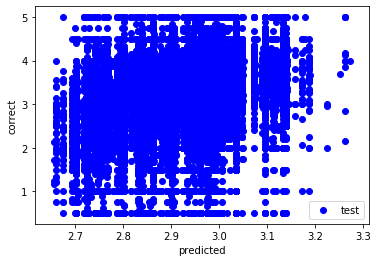


### K-Neighbors Regressor ###
Score (Average):  -0.02702322244405912
MAE:  0.6040767400676931
MSE:  0.6714600603769248
RMSE:  0.819426665649175
R^2:  0.007411169458916955


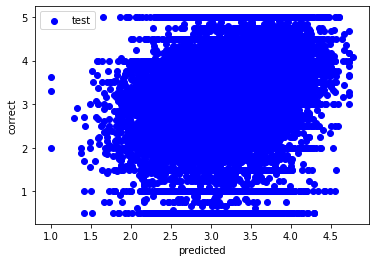


### Random Forest Regressor ###
Score (Average):  -0.07677087010880575
MAE:  0.6016483244946111
MSE:  0.6819857613069847
RMSE:  0.8258242920300811
R^2:  -0.00814849491029146


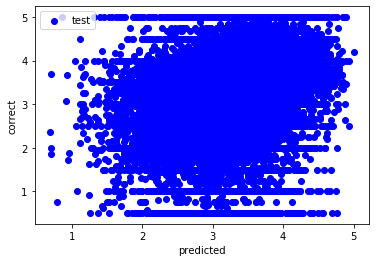


### Random Forest Regressor (different values) ###
Score (Average):  0.12128591704786085
MAE:  0.5528868773506935
MSE:  0.5763534903254974
RMSE:  0.7591794849213837
R^2:  0.14800288103611392


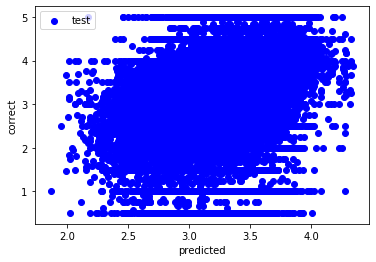


### Gradient Boosting Regressor ###
Score (Average):  0.12886243223815155
MAE:  0.5668955532934716
MSE:  0.5877465328531039
RMSE:  0.7666462892710718
R^2:  0.13116106507995184


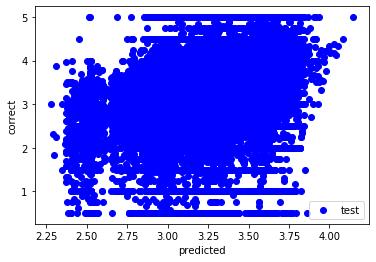


### Gradient Boosting Regressor (different values) ###
Score (Average):  -1.1286245268691923
MAE:  0.9527991965622159
MSE:  1.4257996890755553
RMSE:  1.1940685445465664
R^2:  -1.1076947527912573


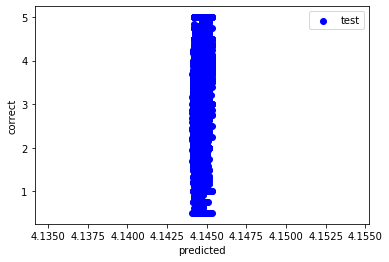

In [19]:
print("### Linear Regression ###")
model = LinearRegression()
executeModel(model)

print("\n### Ridge ###")
model = Ridge()
executeModel(model)

print("\n### Bayesian Ridge ###")
model = BayesianRidge()
executeModel(model)

print("\n### Ada Boost Regressor ###")
model = AdaBoostRegressor(DecisionTreeRegressor())
executeModel(model)

print("\n### Ada Boost Regressor (different values) ###")
ada_tree_backing = DecisionTreeRegressor(max_features='sqrt', splitter='random', min_samples_split=4, max_depth=3)
model = AdaBoostRegressor(ada_tree_backing, learning_rate=0.1, loss='square', n_estimators=1000)
executeModel(model)

print("\n### K-Neighbors Regressor ###")
model = KNeighborsRegressor()
executeModel(model)

print("\n### Random Forest Regressor ###")
model = RandomForestRegressor()
executeModel(model)

print("\n### Random Forest Regressor (different values) ###")
model = RandomForestRegressor(max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2)
executeModel(model)

print("\n### Gradient Boosting Regressor ###")
model = GradientBoostingRegressor()
executeModel(model)

print("\n### Gradient Boosting Regressor (different values) ###")
model = GradientBoostingRegressor(loss='quantile', learning_rate=0.0001, n_estimators=50, max_features='log2', min_samples_split=2, max_depth=1)
executeModel(model)

## 5. Hyperparameter optimization (Grid Search)

Selected Models: Ridge, Random Forest Regressor and Gradient Boosting Regressor

### 5.1. Ridge


### Results ###
Score (Average):  0.0944794321538629
MAE:  0.5812498143353537
MSE:  0.6121754409202249
RMSE:  0.7824164114589014
R^2:  0.09504892271942511


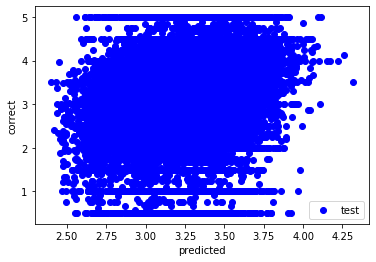

### Best Score ###
0.10101474735143144 with paramater: {'alpha': 100}

### Results of all hyper-parameter combinations ###


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055194,0.004341,0.000446,0.000774,0.001,{'alpha': 0.001},0.096906,0.104506,0.111579,0.094442,0.097780,0.101539,0.103420,0.098619,0.098768,0.102584,0.101014,0.004622,6
1,0.052680,0.007462,0.000100,0.000299,0.1,{'alpha': 0.1},0.096906,0.104506,0.111579,0.094442,0.097780,0.101539,0.103420,0.098619,0.098768,0.102584,0.101014,0.004622,5
2,0.047087,0.008257,0.001217,0.002728,1,{'alpha': 1},0.096906,0.104506,0.111579,0.094442,0.097780,0.101539,0.103420,0.098619,0.098768,0.102584,0.101014,0.004622,4
3,0.049809,0.006489,0.001830,0.004664,10,{'alpha': 10},0.096906,0.104506,0.111578,0.094443,0.097780,0.101539,0.103420,0.098619,0.098769,0.102583,0.101014,0.004622,3
4,0.045816,0.008133,0.004816,0.007362,100,{'alpha': 100},0.096902,0.104501,0.111576,0.094449,0.097780,0.101539,0.103425,0.098620,0.098780,0.102575,0.101015,0.004620,1
5,0.050388,0.005903,0.000401,0.001203,250,{'alpha': 250},0.096896,0.104492,0.111572,0.094459,0.097780,0.101538,0.103432,0.098620,0.098798,0.102560,0.101015,0.004616,2
6,0.052196,0.010402,0.001891,0.004719,500,{'alpha': 500},0.096884,0.104475,0.111564,0.094473,0.097779,0.101536,0.103441,0.098618,0.098824,0.102535,0.101013,0.004611,7


In [20]:
model = Ridge()

parameters = {
    'alpha':[0.001, 0.1, 1, 10, 100, 250, 500]
}

# create the grid search instance
grid = GridSearchCV(model,parameters, cv=10)

# run the grid search
grid.fit(features_train, rating_train)

# results
print("\n### Results ###")
executeModel(grid, withFit=False)

# print the best parameter setting
print("### Best Score ###")
print("{} with paramater: {}".format(grid.best_score_, grid.best_params_))

# print the results of all hyper-parameter combinations
print("\n### Results of all hyper-parameter combinations ###")
results = pd.DataFrame(grid.cv_results_)
display(results)

### 5.2. Random Forest Regressor

In [23]:
model = RandomForestRegressor()

parameters = {
    'n_estimators': [1, 10, 50],
    'max_features': [0.25, 0.5, 1],
    'max_depth': [3, 10, 25]
}

scoring = {'Max Error': 'max_error', 'R^2': 'r2'}

# create the grid search instance
grid = GridSearchCV(model, parameters, scoring=['max_error','r2'], cv=10, return_train_score=False, refit=False)

# run the grid search
grid.fit(features_train, rating_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 10, 25],
    

In [30]:
# print the results of all hyper-parameter combinations
print("\n### Results of all hyper-parameter combinations ###")
results = pd.DataFrame(grid.cv_results_)
display(results.sort_values(by="rank_test_r2"))

<bound method BaseEstimator.get_params of GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_max_error,split1_test_max_error,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
26,6.071001,0.303657,0.407583,0.018646,25,1,50,"{'max_depth': 25, 'max_features': 1, 'n_estima...",-3.539243,-3.422650,...,0.144959,0.136235,0.137609,0.148244,0.137091,0.145074,0.149483,0.145923,0.007588,1
14,6.771080,0.387780,0.151222,0.006284,10,0.5,50,"{'max_depth': 10, 'max_features': 0.5, 'n_esti...",-3.399012,-3.318991,...,0.139146,0.135848,0.138812,0.142454,0.132872,0.140197,0.148313,0.141885,0.008007,2
11,3.911858,0.206992,0.138580,0.007463,10,0.25,50,"{'max_depth': 10, 'max_features': 0.25, 'n_est...",-3.281983,-3.231872,...,0.134794,0.135513,0.136573,0.140469,0.132786,0.137831,0.144726,0.139510,0.007157,3
13,1.459535,0.076825,0.032087,0.005517,10,0.5,10,"{'max_depth': 10, 'max_features': 0.5, 'n_esti...",-3.405872,-3.476009,...,0.133389,0.133129,0.134024,0.141606,0.129260,0.134519,0.144088,0.137956,0.007497,4
10,0.730892,0.022087,0.027887,0.006063,10,0.25,10,"{'max_depth': 10, 'max_features': 0.25, 'n_est...",-3.265501,-3.171059,...,0.132698,0.130423,0.133171,0.137374,0.130189,0.135651,0.143674,0.136074,0.006437,5
20,8.968844,0.505800,0.419977,0.017917,25,0.25,50,"{'max_depth': 25, 'max_features': 0.25, 'n_est...",-3.625582,-3.499386,...,0.129011,0.117633,0.123734,0.128146,0.115370,0.131267,0.131627,0.129362,0.008712,6
23,14.341071,0.393224,0.450327,0.023639,25,0.5,50,"{'max_depth': 25, 'max_features': 0.5, 'n_esti...",-3.647727,-3.556996,...,0.120591,0.111495,0.110437,0.112021,0.106165,0.124404,0.123186,0.119909,0.009606,7
25,1.229803,0.060020,0.086790,0.005269,25,1,10,"{'max_depth': 25, 'max_features': 1, 'n_estima...",-3.833333,-3.751169,...,0.126550,0.106724,0.116100,0.127143,0.102432,0.118581,0.122230,0.118735,0.007823,8
5,2.490571,0.105091,0.055155,0.007296,3,0.5,50,"{'max_depth': 3, 'max_features': 0.5, 'n_estim...",-3.032328,-3.040303,...,0.101416,0.097048,0.100052,0.104142,0.097820,0.099481,0.104560,0.101879,0.004328,9
17,1.755334,0.062950,0.126738,0.006284,10,1,50,"{'max_depth': 10, 'max_features': 1, 'n_estima...",-3.023538,-3.201665,...,0.097604,0.101426,0.101372,0.101259,0.099221,0.098661,0.104630,0.101116,0.003591,10


Score (Average):  0.09189000398436671
MAE:  0.5486283186771073
MSE:  0.5787796575318989
RMSE:  0.7607756946248341
R^2:  0.14441638853684702


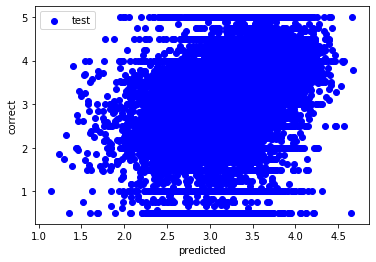

In [31]:
# max_depth = 25, max_features = 1, n_estimators=50
model = RandomForestRegressor(max_depth=25,max_features=1,n_estimators=50)
executeModel(model)

### 5.3. Gradient Boosting Regressor

In [ ]:
model = GradientBoostingRegressor()

parameters = {
    'learning_rate': [0.01,0.03],
    'subsample'    : [0.9, 0.5, 0.2],
    'n_estimators' : [100,500,1000],
    'max_depth'    : [4,8] 
}

# create the grid search instance
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 10, n_jobs=-1)

# run the grid search
grid.fit(features_train, rating_train)

In [ ]:
# 
model = GradientBoostingRegressor(?)
executeModel(model)

## 5. Pipeline

We need to import all data with all features again because we will include RFECV to our pipeline as feature selector.

In [ ]:
rating = df_joined_pipeline['rating']
features = df_joined_pipeline.drop(columns=['rating'])

features_train, features_test, rating_train, rating_test = train_test_split(
    features, rating, test_size=0.3, random_state=42)

print("Train: " + str(len(features_train)) + " Feature Entries and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features Entries and " + str(len(rating_test)) + " Ratings")

### 5.1. Ridge

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# create a transformer and linear regression
transformer = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()
estimator = Ridge(alpha = 100)

# create the feature selection estimator
feature_selection = RFECV(estimator, cv=10)

# setup the pipeline
pipeline = Pipeline([ ('transformer', transformer), ('scaler', scaler), ('feature_selection', feature_selection)])

# evaluate
executeModel(pipeline)

# get the selected features
fs = pipeline.named_steps['feature_selection']
est = pipeline.named_steps['feature_selection'].estimator_

selected_features = fs.get_support()
feature_index = 0

print("\n### Regression Formula (Model) ###")
print("rating = ", end='')
for i, f in enumerate(pipeline.named_steps['transformer'].get_feature_names()):
    # check if the feature was selected
    if selected_features[i]:
        if i > 0:
            print(" + ", end='')
        print("{}*{}".format(est.coef_[feature_index], f), end='')
        feature_index += 1
print(" + {}".format(est.intercept_))

### 5.2. Random Forest Regressor

### 5.3. Gradient Boosting Regressor